In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [28]:
# Set style for visualizations
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("husl")

In [30]:
# 1. Load and Prepare Data
df = pd.read_csv(r"C:\Users\ASUS\Downloads\cleaned_clinic_data.csv")


In [32]:
# Convert target - we'll predict No-Shows vs all others
df['No-show'] = df['Status'].apply(lambda x: 1 if x == 'No-Show' else 0)

In [52]:
# 2. Select Specific Features
features = ['LVM_Flag', 'Severity']  # Focus on these two key features
X = df[features]
y = df['No-show']


In [54]:
# 3. Check for Missing Values
print("Missing values in each feature:")
print(X.isnull().sum())

Missing values in each feature:
LVM_Flag    0
Severity    0
dtype: int64


In [56]:
# 4. Preprocessing Pipeline
# LVM_Flag is binary (0/1) - just needs imputation
# Severity is categorical - needs imputation and encoding

numeric_features = ['LVM_Flag']
categorical_features = ['Severity']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [58]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# 6. Logistic Regression Model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=1000, 
                                                         random_state=42, 
                                                         class_weight='balanced'))])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['LVM_Flag']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Severity'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [62]:
# 7. Model Evaluation
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n=== Model Evaluation ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


=== Model Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       162
           1       0.28      0.25      0.26       100

    accuracy                           0.47       262
   macro avg       0.42      0.42      0.42       262
weighted avg       0.45      0.47      0.46       262


Confusion Matrix:
[[97 65]
 [75 25]]

ROC AUC Score: 0.4150617283950617


In [40]:
# 5. Logistic Regression Model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(max_iter=1000, 
                                                          random_state=42, 
                                                          class_weight='balanced'))])

In [42]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DaysWarning',
                                                   'DaysUntilAppointment']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Code', 'Provider',
                                                   'CancellationType',
                                                   'AppointmentDayOfWeek',
                                                   'AppointmentMonth'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [44]:
# 6. Model Evaluation
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

print("=== Model Evaluation ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

=== Model Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       100

    accuracy                           1.00       262
   macro avg       1.00      1.00      1.00       262
weighted avg       1.00      1.00      1.00       262


Confusion Matrix:
[[162   0]
 [  0 100]]

ROC AUC Score: 1.0


In [64]:
# 8. Feature Importance Analysis
# Get feature names after one-hot encoding
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
severity_categories = encoder.get_feature_names_out(['Severity'])
all_features = ['LVM_Flag'] + list(severity_categories)

# Get coefficients
coefficients = pipeline.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': all_features, 
                                 'Coefficient': coefficients,
                                 'Odds_Ratio': np.exp(coefficients)})
feature_importance = feature_importance.sort_values('Odds_Ratio', ascending=False)

print("\n=== Feature Importance ===")
print(feature_importance)


=== Feature Importance ===
             Feature  Coefficient  Odds_Ratio
2  Severity_Moderate     0.121694    1.129408
0           LVM_Flag     0.045886    1.046955
1      Severity_Mild     0.014837    1.014947
4   Severity_Unknown    -0.024607    0.975693
3    Severity_Severe    -0.137579    0.871465


In [48]:
# 7. Feature Importance Analysis
# Get feature names after one-hot encoding
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

# Get coefficients
coefficients = pipeline.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': all_features, 
                                 'Coefficient': coefficients,
                                 'Abs_Coefficient': abs(coefficients),
                                 'Odds_Ratio': np.exp(coefficients)})
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\n=== Top 20 Most Important Features ===")
print(feature_importance.head(20)[['Feature', 'Coefficient', 'Odds_Ratio']])


=== Top 20 Most Important Features ===
                          Feature  Coefficient  Odds_Ratio
125  CancellationType_ShortNotice    -4.229644    0.014558
124      CancellationType_No-Show     4.227998   68.579789
99                    Provider_34     0.156327    1.169208
19                      Code_COMP     0.147486    1.158917
105                   Provider_51    -0.139679    0.869637
75                   Provider_1ND     0.119245    1.126646
104                   Provider_50    -0.096952    0.907599
126   AppointmentDayOfWeek_Friday     0.091008    1.095278
102                   Provider_42     0.084529    1.088204
53                     Code_ORT-2     0.079024    1.082230
137         AppointmentMonth_July    -0.077471    0.925453
36                       Code_EXO    -0.071067    0.931400
95                   Provider_2SP    -0.068487    0.933806
119                  Provider_5RP     0.068471    1.070869
116                  Provider_5MP    -0.063895    0.938104
70              

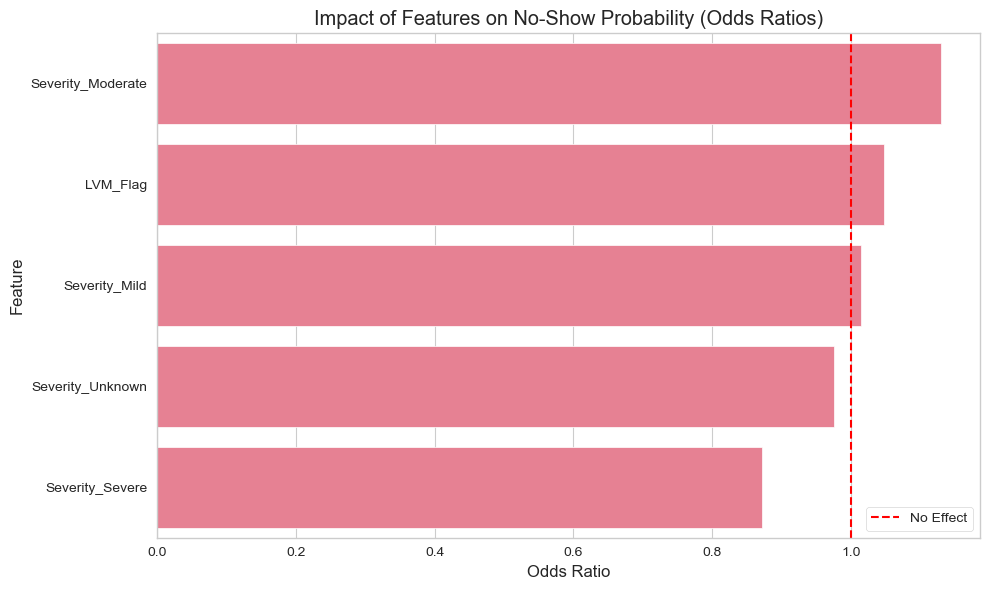

In [66]:
# 9. Visualizing Feature Effects
plt.figure(figsize=(10, 6))
sns.barplot(x='Odds_Ratio', y='Feature', data=feature_importance)
plt.title('Impact of Features on No-Show Probability (Odds Ratios)')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.axvline(1, color='red', linestyle='--', label='No Effect')
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
# 10. Practical Impact Analysis
print("\n=== Practical Impact Analysis ===")
baseline_prob = df['No-show'].mean()
print(f"Baseline no-show probability: {baseline_prob:.1%}")

for feature in feature_importance['Feature']:
    coef = feature_importance.loc[feature_importance['Feature'] == feature, 'Coefficient'].values[0]
    odds_ratio = np.exp(coef)
    
    # Calculate probability change
    new_odds = (baseline_prob/(1-baseline_prob)) * odds_ratio
    new_prob = new_odds / (1 + new_odds)
    change = (new_prob - baseline_prob)*100
    
    direction = "increases" if coef > 0 else "decreases"
    print(f"{feature}: {direction} no-show probability by {abs(change):.1f}% (OR: {odds_ratio:.2f})")



=== Practical Impact Analysis ===
Baseline no-show probability: 37.5%
Severity_Moderate: increases no-show probability by 2.9% (OR: 1.13)
LVM_Flag: increases no-show probability by 1.1% (OR: 1.05)
Severity_Mild: increases no-show probability by 0.3% (OR: 1.01)
Severity_Unknown: decreases no-show probability by 0.6% (OR: 0.98)
Severity_Severe: decreases no-show probability by 3.2% (OR: 0.87)


In [70]:
# 11. Group Analysis
print("\n=== No-Show Rates by Feature ===")
print("\nBy LVM_Flag:")
print(df.groupby('LVM_Flag')['No-show'].mean())

print("\nBy Severity:")
print(df.groupby('Severity')['No-show'].mean().sort_values(ascending=False))


=== No-Show Rates by Feature ===

By LVM_Flag:
LVM_Flag
0    0.377907
1    0.364130
Name: No-show, dtype: float64

By Severity:
Severity
Mild        0.393082
Severe      0.391304
Unknown     0.369128
Moderate    0.352381
Name: No-show, dtype: float64
